In [2]:
import torch

import triton
import triton.language as tl
 
DEVICE = torch.device("cuda:0")

In [ ]:
@triton.jit
def layer_norm_fwd(
    X,  # input
    Y,  # output
    W,  # weights
    B,  # biases
    Mean,  # means
    Rstd,  # 1/stds
    M,  # number of rows in X: for each row, we launch a block
    N,  # number of columns in X
    eps,  # epsilon to avoid division by zero
    BLOCK_SIZE: tl.constexpr, # Assume N < BLOCK_SIZE
):
    pid = tl.program_id(0)
    X += pid * N
    Y += pid * N
    # compute mean
    mean = 0
    _mean = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    cols = tl.arange(0, BLOCK_SIZE)
    a = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
    _mean += a
    mean = tl.sum(_mean, axis=0) / N
    # compute variance
    _var = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    cols = tl.arange(0, BLOCK_SIZE)
    x = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
    x = tl.where(cols < N, x - mean, 0.)
    _var += x * x

    var = tl.sum(_var, axis=0) / N
    rstd = 1 / tl.sqrt(var + eps)
    # write mean / rstd
    tl.store(Mean + pid, mean)
    tl.store(Rstd + pid, rstd)
    # layer normalization
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < N
    w = tl.load(W + cols, mask=mask)
    b = tl.load(B + cols, mask=mask)
    x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32)
    x_hat = (x - mean) * rstd
    # element-wise product & addition
    y = x_hat * w + b
    # Write output
    tl.store(Y + cols, y, mask=mask)

For back prop, use a 2-stage setup.

- Stage 1: Compute DX, DW, DB for each row.
           DW and DB needs to be accumulated across the batch.
           We first reduce them into GROUP_SIZE_M partial sums, 
           so that it would be retained in L2.
           (Improve L2 cache locality & avoid write contention.)
           Lock and Inited is also very likely to be retained in L2 -
           They are small and frequently accessed.

- Stage 2: Reduce GROUP_SIZE_M partial sums. 
           This can be faster because more reduce is done on registers or SRAM.
           

Trade-off on GROUP_SIZE_M: it's a key knob. 
- Too small -> too many partials -> more work for stage 2
- Too big -> more contention and higher L2 pressure

In [ ]:
@triton.jit
def layer_norm_bwd_stage1(
    DX, # input gradient
    DY, # output gradient
    DW,
    DB,
    X, # input
    W, # weights
    Mean,
    Rstd,
    Lock, # [atomic lock] ++ [inited] (to mark if it's initialized)
    M, # batch dim
    N, # vec dim
    # each block processes a row
    GROUP_SIZE_M: tl.constexpr,
    # BLOCK_SIZE_N >= N
    BLOCK_SIZE_N: tl.constexpr,
):
    """
    Stage 1: Compute DX, DW, DB for each row.
        DW and DB needs to be accumulated across the batch.
        We first reduce them into GROUP_SIZE_M partial sums, 
        so that it would be retained in L1 / L2.
        (Improve cache locality & avoid write contention.)
        Lock and Inited is also very likely to be retained in cache -
        They are small and frequently accessed.
    """
    pid = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE_N)
    mask = cols < N
    # move pointers to the starting vec (batch)
    X += pid * N
    DY += pid * N
    DX += pid * N
    # locks for each group
    lock_id = pid % GROUP_SIZE_M
    Lock += lock_id
    # init flags for each group 
    Inited = Lock + GROUP_SIZE_M
    DW = DW + lock_id * N + cols
    DB = DB + lock_id * N + cols

    x = tl.load(X + cols, mask=mask, other=0.0).to(tl.float32)
    dy = tl.load(DY + cols, mask=mask, other=0.0).to(tl.float32)
    w = tl.load(W + cols, mask=mask, other=0.0).to(tl.float32)
    mean = tl.load(Mean + pid)
    rstd = tl.load(Rstd + pid)

    # computing input gradient
    hat_x = (x - mean) * rstd
    w_x_dy = w * dy
    c0 = tl.sum(w_x_dy, axis=0) / N
    c1 = tl.sum(w_x_dy * hat_x, axis=0) / N
    tl.store(DX + cols, rstd * (w_x_dy - c0 - c1 * hat_x), mask=mask)

    # accumulate partial gradient for w & b for each row
    partial_dw = (dy * hat_x).to(w.dtype)
    partial_db = dy.to(w.dtype)

    # get spinlock
    # lock is on global memory, but should be fast because L2 retains it
    while tl.atomic_cas(Lock, 0, 1) == 1:
        pass
    inited = tl.load(Inited)
    # first store does not accumulate
    if inited == 0:
        tl.atomic_xchg(Inited, 1)
    else:
        partial_dw += tl.load(DW, mask=mask)
        partial_db += tl.load(DB, mask=mask)
    tl.store(DW, partial_dw, mask=mask)
    tl.store(DB, partial_db, mask=mask)

    # __sync_threads()
    tl.debug_barrier()
    tl.atomic_xchg(Lock, 0)

@triton.jit
def layer_norm_bwd_stage2(
    DW,
    DB,
    RES_DW,
    RES_DB,
    GROUP_SIZE_M,
    N,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr
    # we divide N into blocks of BLOCK_SIZE_N and run sum on all groups
):
    """
    Stage 2: Reduce GROUP_SIZE_M partial sums. 
        This is faster because reduce is done on registers (warp reduce).
    """
    pid = tl.program_id(0)
    cols = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    dw = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for i in range(0, GROUP_SIZE_M, BLOCK_SIZE_M):
        rows = i + tl.arange(0, BLOCK_SIZE_M)
        mask = (rows[:, None] < GROUP_SIZE_M) & (cols[None, :] < N)
        offs = rows[:, None] * N + cols[None, :]
        dw += tl.load(DW + offs, mask=mask, other=0.0)
        db += tl.load(DB + offs, mask=mask, other=0.0)
    sum_dw = tl.sum(dw, axis=0)
    sum_db = tl.sum(db, axis=0)
    tl.store(RES_DW + cols, sum_dw, mask=(cols < N))
    tl.store(RES_DB + cols, sum_db, mask=(cols < N))

=== Specs ===
Name: NVIDIA RTX A6000
SM Count: 84
Device Memory: 49139 MB

=== Testing 512x512 Matrix ===

=== Running Benchmark ===


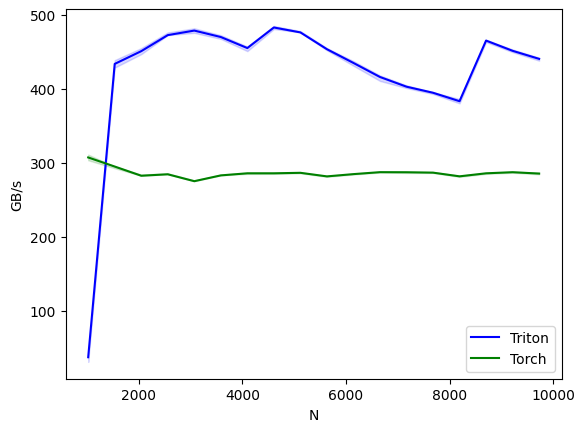

layer-norm-backward:
         N      Triton       Torch
0   1024.0   37.067874  307.200008
1   1536.0  433.694119  294.911986
2   2048.0  450.935778  282.482757
3   2560.0  472.615383  284.444444
4   3072.0  478.753266  275.104474
5   3584.0  470.032796  282.947381
6   4096.0  455.111110  285.767442
7   4608.0  482.934503  285.767436
8   5120.0  476.279097  286.433562
9   5632.0  453.583894  281.600007
10  6144.0  434.973463  284.664100
11  6656.0  415.999985  287.309361
12  7168.0  402.885254  287.198654
13  7680.0  394.689503  286.656296
14  8192.0  383.251457  281.673345
15  8704.0  465.247202  285.767450
16  9216.0  451.395913  287.251954
17  9728.0  440.513191  285.418093


In [7]:
class LayerNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps):
        # allocate output
        y = torch.empty_like(x)
        # reshape input data into 2D tensor
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        mean = torch.empty((M, ), dtype=torch.float32, device=x.device)
        rstd = torch.empty((M, ), dtype=torch.float32, device=x.device)
        # Less than 64KB per feature: enqueue fused kernel
        MAX_FUSED_SIZE = 65536 // x.element_size()
        BLOCK_SIZE = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
        if N > BLOCK_SIZE:
            raise RuntimeError("This layer norm doesn't support feature dim >= 64KB.")
        # heuristics for number of warps
        num_warps = min(max(BLOCK_SIZE // 256, 1), 8)
        # enqueue kernel
        layer_norm_fwd[(M, )](
            x_arg, y, weight, bias, mean, rstd, M, N, eps,
            BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps, num_ctas=1
        )
        ctx.save_for_backward(x, weight, bias, mean, rstd)
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps = num_warps
        ctx.eps = eps
        return y

    @staticmethod
    def backward(ctx, dy):
        x, w, b, m, v = ctx.saved_tensors
        # heuristics for amount of parallel reduction stream for DW/DB
        N = w.shape[0]
        GROUP_SIZE_M = 64
        if N <= 8192: GROUP_SIZE_M = 96
        if N <= 4096: GROUP_SIZE_M = 128
        if N <= 1024: GROUP_SIZE_M = 256
        # allocate output
        locks = torch.zeros(2 * GROUP_SIZE_M, dtype=torch.int32, device=w.device)
        _dw = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        _db = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        dw = torch.empty((N, ), dtype=w.dtype, device=w.device)
        db = torch.empty((N, ), dtype=w.dtype, device=w.device)
        dx = torch.empty_like(dy)
        # enqueue kernel using forward pass heuristics
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        layer_norm_bwd_stage1[(M, )](
            dx, dy, _dw, _db, x, w, m, v, locks,
            M, N,
            BLOCK_SIZE_N=ctx.BLOCK_SIZE,
            GROUP_SIZE_M=GROUP_SIZE_M,
            num_warps=ctx.num_warps)
        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_SIZE_N']), )
        layer_norm_bwd_stage2[grid](
            _dw, _db, dw, db, min(GROUP_SIZE_M, M), N, 
            BLOCK_SIZE_M=32,
            BLOCK_SIZE_N=128, num_ctas=1)
        return dx, None, dw, db, None

layer_norm = LayerNorm.apply

def test_layer_norm(M, N, dtype, eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    # forward pass
    y_tri = layer_norm(x, w_shape, weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    # backward pass (triton)
    y_tri.backward(dy, retain_graph=True)
    dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None
    # backward pass (torch)
    y_ref.backward(dy, retain_graph=True)
    dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
    # compare
    assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=1e-2)
    assert torch.allclose(dx_tri, dx_ref, atol=1e-2, rtol=1e-2)
    assert torch.allclose(db_tri, db_ref, atol=1e-2, rtol=1e-2)
    assert torch.allclose(dw_tri, dw_ref, atol=1e-2, rtol=1e-2)


@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 20)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'backward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():

        if provider == "triton":
            return layer_norm(x, w_shape, weight, bias, eps) 

        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

if __name__ == "__main__":
    print("=== Specs ===")
    specs = torch.cuda.get_device_properties(DEVICE)
    print("Name:", specs.name)
    print("SM Count:", specs.multi_processor_count)
    print("Device Memory:", specs.total_memory // (1024 ** 2), "MB")
    print("\n=== Testing 512x512 Matrix ===")
    test_layer_norm(1151, 8192, torch.float16)
    print("\n=== Running Benchmark ===")
    bench_layer_norm.run(show_plots=True, print_data=True)